# DDPG :: re-wheeler project for Reacher UnityML environment
---

### 1. Import the Necessary Packages

In [1]:
import torch
from task import Task, update_goal_curyctor
from alchemy.bot import Bot, BrainDescription
from alchemy.env import Env

from utils.crossexp import *

from utils.encoders import *
from utils.rnn import *
import model

from utils.replay import ReplayBuffer

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Load CONFIG :: TODO -> more implicit config ( trough .toml and all in one place, lot is now in 5th cell )

In [2]:
TOTAL_ENV = 20
STATE_SIZE = 33 - 3
ACTION_SIZE = 4
N_STEP = 10#3

N_HISTORY = 1#2#

N_REWARDS = 9
N_ACTORS = 1
MAX_STEPS = 70

### 3. Setup dummies ( unused feats in this environment )

In [3]:
def Encoder():
    return StackedEncoder(
            GlobalNormalizer(STATE_SIZE, N_HISTORY),
            FasterGRUEncoder(STATE_SIZE, N_HISTORY, 2 * 48, 2))

### 4. Set model wrappers

In [4]:
def Actor(encoder):
    nes_layers = [encoder.out_size(), 400, 300, ACTION_SIZE]
    return lambda: model.ActorFactory(nes_layers, torch.tanh, action_size=ACTION_SIZE, ddpg=True)

def Critic(encoder):
    return lambda: model.Critic(N_ACTORS, N_REWARDS, encoder.out_size(), ACTION_SIZE, lambda x: x)

def callback(bot, task, test_scores, learn_scores, seeds, total):
    if test_scores is None:
        return
    print("\n\t==> test round with ", len(test_scores), test_scores, np.mean(learn_scores))
def dbgout(bot, score, actions):
    return


### 5. Setup && run agent/bot

In [5]:
replay_ddpg = ReplayBuffer(
            n_step=N_STEP, replay_reanalyze=True,
            buffer_size=MAX_STEPS * TOTAL_ENV * 500, select_count=4, max_ep_draw_count=40,
            alpha=.7, beta_base=.3, beta_end=.7, beta_horizon=10000,
            recalc_delta=3)

encoder = Encoder()
brain_descriptions = [
        BrainDescription( # master :: PPO
            ddpg=True,
            count=TOTAL_ENV, n_groups=TOTAL_ENV, Actor=Actor(encoder), Critic=Critic(encoder),
            model_path="x_ddpg_checkpoints", save=True, load=True, delay=1,
            resample_delay=N_STEP,
            good_reach=1, replay_buffer=replay_ddpg, batch_size=128,
            sync_delta=3, learning_delay=N_STEP * 1, learning_repeat=20 * 1,
            fresh_frac=10, optim_epochs=3,
            ppo_eps=None, dbgout=False,
            adv_on=True, adv_boost=False,                
            lr_actor=8e-4, lr_critic=3e-4, clip_norm=1.,
            tau_replay_counter=1, tau_base=1e-3, tau_final=1e-3,
            replay_cleaning=False, prob_treshold=None),
    ]

bot = Bot(
# brain configs
        encoder,
        brain_descriptions,

        n_actors=2, n_critics=1,
        n_history=N_HISTORY, state_size=STATE_SIZE, action_size=ACTION_SIZE,
        n_step=N_STEP, floating_step=True, gamma=.99,

# agent configs
        update_goal=update_goal_curyctor(N_STEP),
        her_max_ratio=3,
        gae=True, gae_tau=.95,
        freeze_delta=20, freeze_count=30,
        )

task = Task()

env = Env(bot, task,
        total_envs=TOTAL_ENV, n_history=N_HISTORY, history_features=encoder.features_n(), state_size=encoder.in_size(),
        n_step=N_STEP, send_delta=N_STEP * 1,
        eval_limit=100, eval_ratio=.5, max_n_episode=MAX_STEPS, eval_delay=20,
        mcts_random_cap=1000, mcts_rounds=1)

scores = env.start(callback, dbgout)
losses = bot.brains[0].get_losses()

[   20>  1419:: 0] steps =   70, max_step =  71/ 70, reward=0.023556 <action=[ 1. -1. -1. -1.]>                    
	==> test round with  1 [1.8289999591186599] 0.023944444444444452
[   40>  2839:: 0] steps =   70, max_step =  71/ 70, reward=0.023611 <action=[-1.  1. -1. -1.]>                    
	==> test round with  1 [3.251499927323299] 0.024777777777777784
[   60>  4259:: 0] steps =   70, max_step =  71/ 70, reward=0.055000 <action=[-1.  1. -1. -1.]>                    
	==> test round with  1 [3.616499919164915] 0.056222222222222215
[   80>  5679:: 0] steps =   70, max_step =  71/ 70, reward=0.053778 <action=[-0.2053617 -1.        -1.        -1.       ]>                    
	==> test round with  1 [5.077999886497852] 0.05427777777777776
[  100>  7099:: 0] steps =   70, max_step =  71/ 70, reward=0.084500 <action=[-1.  1. -1. -1.]>                    
	==> test round with  1 [5.990499866101878] 0.08588888888888886
[  120>  8519:: 0] steps =   70, max_step =  71/ 70, reward=0.074611

In [7]:
scores = np.asarray(scores[1:]).flatten()
losses_ex = losses
losses = np.vstack(losses_ex)[::len(losses_ex)//200]

### 4. Plot reward + loss

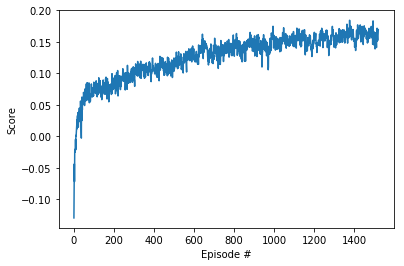

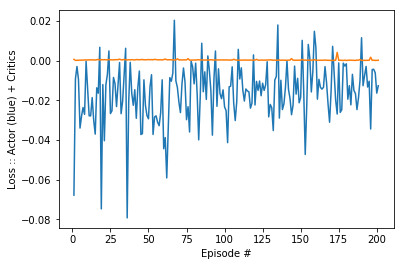

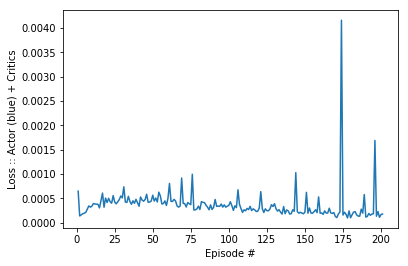

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses)+1), losses)
plt.ylabel('Loss :: Actor (blue) + Critics')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses)+1), losses[:, 1:])
plt.ylabel('Loss :: Actor (blue) + Critics')
plt.xlabel('Episode #')
plt.show() 

### 4. Reload trained agent

In [10]:
bot.sync_target(0, 0, [])
bot.sync_explorer(0, 0, [])

### 5. Test visuals - TARGET


 environment solved!  32.0604892833922
[32.440999274887155, 33.37649925397707, 32.55799927227205, 31.113499304559078, 32.14049928160384, 32.68499926943329, 31.622499293182006, 32.5324992728419, 30.777999312058085, 31.189999302849102, 31.51499929558484, 31.882999287359365, 31.748999290354597, 31.36199929900465, 31.927999286353664, 32.08449928285558, 31.57099929433321, 31.72049929099158, 32.922999264113635, 32.10549928238615, 32.706499268952726, 32.711499268841, 32.03849928388367, 30.366999321244677, 32.65849927002568, 32.599999271333175, 30.605499315913768, 32.19199928045269, 31.525999295338995, 31.09149930505085, 30.687999314069756, 30.59999931603666, 32.12549928193911, 32.65649927007034, 31.471999296546013, 31.841999288275858, 31.962499285582464, 32.46849927427244, 33.09149926034737, 32.208499280083906, 32.42749927518884, 34.05649923877795, 32.97849926287308, 30.619999315589716, 32.270999278686965, 32.03949928386132, 31.984999285079518, 32.96199926324189, 31.94299928601832, 33.151999

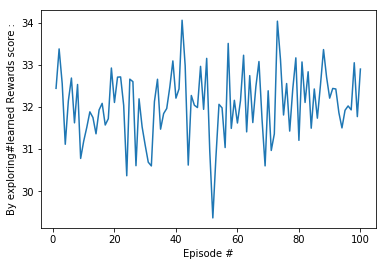

In [11]:
rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate()
    for s in np.asarray(scores).flatten():
        rewards.append(s)
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By exploring#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()

### 6. Test visuals - EXPLORER

mean rewards :  24.254479457870115


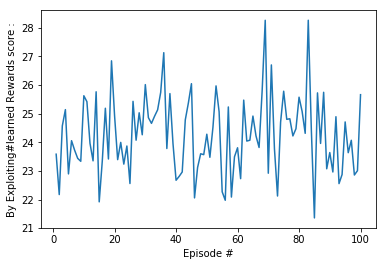

In [12]:
# for evaluation we will set target network to be explorer
bot.brains[0].ac_target = bot.brains[0].ac_explorer

rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate()
    for s in np.asarray(scores).flatten():
        rewards.append(s)
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By Exploiting#learned Rewards score :')
plt.xlabel('Episode #')
plt.show() 